## 高斯朴素贝叶斯分类器
### 准备数据
本文的训练/测试数据都来自`sklearn`的高斯混合模型(Gaussian Mixture Model)：

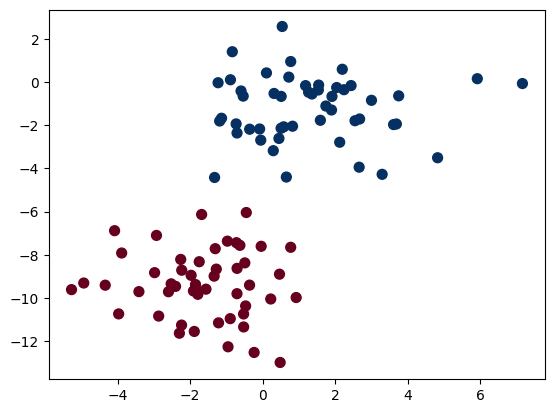

In [106]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np

# 高斯混合模型(Gaussian Mixture Model)，可用于无监督学习中的聚类数据
# 采样数n_smaples，特征数n_feature，X.shape=(n_smaples,n_feature)，y.shape=(n_smaples,)
# centers指定了数据类别的个数
X, y = make_blobs(n_samples=100, n_features=2 ,centers=2, random_state=2, cluster_std=1.5)
fig, gmmAx = plt.subplots()
gmmAx.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')

### 训练模型

假设上图两组数据服从一共两个维度之间没有协(独立)方差的正态分布。根据样点的均值和标准差就能通过正态分布拟合模型了。通过此模型，可以得到特征的条件概率 $P({\rm features}~|~L)$，以及标签的先验概率 $P(L)$。因此，结合贝叶斯定理，我们就能得到，正对给定数据(特征)，各分类标签的后验概率 $P(L|{\rm features})$。我们选取最大的后验概率，作为预测的分类标签的结果。

假设所有特征服$x_i$从独立正态分布，其条件概率密度函数为：
$$P(x_i | y_k)=\frac{1}{\sqrt{2\pi\sigma^2_{yk}}}exp(-\frac{(x_i-\mu_{yk})^2}{2\sigma^2_{yk}})$$

数学期望(mean)：$\mu$

方差：$\sigma^2=\frac{\sum(X-\mu)^2}{N}$

训练出概率分布模型后，将测试数据$x$输入分到后验概率最大的类$y$：

$$y=\arg \max _{c_{k}} P\left(Y=c_{k}\right) \prod_{j=1}^{n} P\left(X_{j}=x^{(j)} | Y=c_{k}\right)$$

后验概率最大等价于0-1损失函数时的期望风险最小化。

In [107]:
import math
from collections import Counter

class GaussianNB:
    def __init__(self):
        self.x_cond_prob = {}
        self.y_prior_prob = {}

    # 数学期望
    def mean(self, X):
        return sum(X) / len(X)

    # 标准差（方差）
    def stdev(self, X):
        avg = self.mean(X)
        return math.sqrt(sum([pow(x - avg, 2) for x in X]) / len(X))

    # 概率密度函数
    def get_gaussian_prob(self, x, mean, stdev):
        exponent = math.exp(-(math.pow(x - mean, 2) / (2 * math.pow(stdev, 2))))
        return (1 / (math.sqrt(2 * math.pi) * stdev)) * exponent

    # 求各特征的期望和标准差
    def calc_x_mean_stdev(self, train_data):
        mean_stdev = [(self.mean(i), self.stdev(i)) for i in zip(*train_data)]
        return mean_stdev

    # 求标签的先验概率
    def calc_y_prior_prob(self, y):
        for label, cnt in Counter(y).items():
            self.y_prior_prob[label] = cnt / len(y)

    def calc_x_cond_prob(self, X, y):
        data = {}
        for features, label in zip(X, y):
            data.setdefault(label, [])
            data[label].append(features)
        for label, value in data.items():
            self.x_cond_prob[label] = self.calc_x_mean_stdev(value)

    # 拟合数据
    def fit(self, X, y):
        self.calc_y_prior_prob(y)
        self.calc_x_cond_prob(X, y)
        return 'gaussianNB train done!'

    # 计算概率
    def calc_y_post_probs(self, input_data):
        probs = {}
        for label, dist in self.x_cond_prob.items():
            probs[label] = self.y_prior_prob[label]
            for i in range(len(dist)):
                mean, stdev = dist[i]
                probs[label] *= self.get_gaussian_prob(input_data[i], mean, stdev)
        return probs

    # 预测分类
    def predict(self, X_test):
        Y_pred = []
        for X_one in X_test:
            # sort with value from tuple (label, value), and get the last one label
            label = sorted(
                self.calc_y_post_probs(X_one).items(),
                key=lambda x: x[-1])[-1][0]
            Y_pred.append(label)
        return np.array(Y_pred)

# 训练模型
model = GaussianNB()
model.fit(X, y)

'gaussianNB train done!'

通过和`sklearn`的高斯朴素贝叶斯分类器的结果的对比，我们可以验证结果是否正确。`sklearn`提供了标准的高斯朴素贝叶斯分类器：

In [108]:
from sklearn.naive_bayes import GaussianNB
model_golden = GaussianNB()
model_golden.fit(X, y)

GaussianNB()

### 预测分类结果
得到模型后，我们创建一些新数据进行测试：

In [109]:
rng = np.random.RandomState(0)
# 产生特征1的范围(-6, 8)，特征2的范围(-14, 4)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)

将测试数据`Xnew`和训练数据`X`，就能看到分类判定的边界位置：

different label: []


Text(0.5, 0.98, 'Gaussian Naive Bayes')

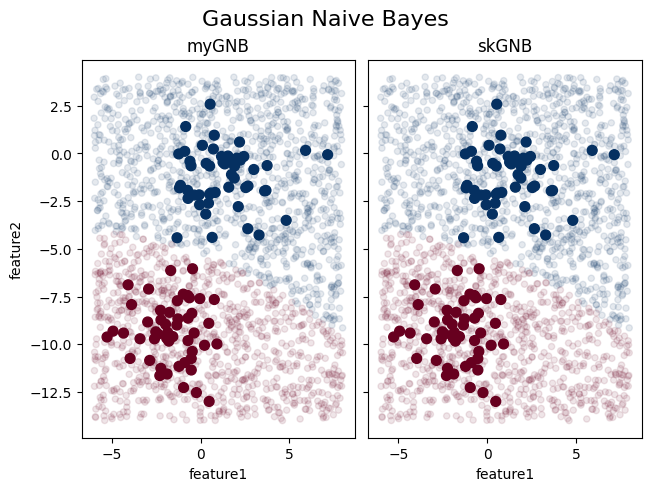

In [110]:
ynew = model.predict(Xnew)
ynew_golden = model_golden.predict(Xnew)
diff = ynew - ynew_golden
print(f'different label: {diff[np.nonzero(diff)]}')

fig, ax = plt.subplots(1, 2, constrained_layout=True, sharey=True)
ax[0].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
ax[0].scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
ax[0].set_title("myGNB")
ax[0].set_xlabel('feature1')
ax[0].set_ylabel('feature2')

ax[1].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
ax[1].scatter(Xnew[:, 0], Xnew[:, 1], c=ynew_golden, s=20, cmap='RdBu', alpha=0.1)
ax[1].set_title("skGNB")
ax[1].set_xlabel('feature1')

fig.suptitle('Gaussian Naive Bayes', fontsize=16)